In [6]:
import pandas as pd
import numpy as np
import os
import math

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
# use get_db_url function to connect to the codeup db
from env import get_db_url
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error

from sklearn.cluster import KMeans, dbscan
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression,  LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler


import zillow_wrangle

In [7]:
# Bringing in the zillow data set
df = zillow_wrangle.wrangle_zillow()

In [8]:
# the wrangle function cut off roughly 7000 results
df.shape

(79661, 22)

In [9]:
df = zillow_wrangle.latlong_to_cart(df)

In [10]:
df.head()

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,yearbuilt,latitude,longitude,taxamount,lotsizesquarefeet,rawcensustractandblock,...,lat,long,bed_bath_ratio,house_age,coslat,coslong,sinlong,x,y,z
0,3.0,2.0,1614.0,1106837.0,1923.0,34045401.0,-118433920.0,13343.01,6767.0,6.037267e+07,...,34.045401,-118.433920,1.500000,94.0,-0.871708,0.584445,0.811434,-0.509465,-0.707334,-0.775711
1,3.0,2.0,1409.0,295907.0,1962.0,33814427.0,-118033546.0,3519.46,6000.0,6.059110e+07,...,33.814427,-118.033546,1.500000,55.0,-0.736380,0.221957,0.975056,-0.163445,-0.718012,0.960066
2,4.0,4.0,1906.0,610663.0,1929.0,33952853.0,-118443334.0,7430.75,5520.0,6.037278e+07,...,33.952853,-118.443334,1.000000,88.0,-0.822692,0.592057,0.805896,-0.487081,-0.663004,0.651727
3,2.0,2.0,1839.0,300205.0,1963.0,34078654.0,-117877174.0,3895.71,7119.0,6.037404e+07,...,34.078654,-117.877174,1.000000,54.0,-0.887518,0.067398,0.997726,-0.059817,-0.885500,0.997168
4,4.0,3.0,2316.0,399945.0,1967.0,34440226.0,-119295368.0,4912.24,11463.0,6.111001e+07,...,34.440226,-119.295368,1.333333,50.0,-0.993129,0.996377,0.085050,-0.989531,-0.084466,0.967165


In [11]:
def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return rho, phi

df['rho'], df['phi'] = cart2pol(df.x, df.y)

In [12]:
df = zillow_wrangle.keep_col(df)

In [13]:
df.isnull().sum()

bedroomcnt                          0
bathroomcnt                         0
calculatedfinishedsquarefeet       13
taxvaluedollarcnt                   1
yearbuilt                          46
latitude                            0
longitude                           0
taxamount                           6
lotsizesquarefeet                1572
rawcensustractandblock              0
roomcnt                             0
poolcnt                             0
regionidcounty                      0
garagecarcnt                        0
logerror17                      14751
logerror16                      62961
transaction17                   14751
transaction16                   62961
lat                                 0
long                                0
bed_bath_ratio                      0
house_age                          46
coslat                              0
coslong                             0
sinlong                             0
x                                   0
y           

The null values for log error and transaction is a result from the sql query. I will merge them so that there are no null values in those two columns
Due to the small size of the other nulls, I will just drop them from the data frame

In [14]:
df['logerror'] = 0
df.loc[~df['logerror17'].isnull(), 'logerror'] = df.loc[~df['logerror17'].isnull(), 'logerror17']
df.loc[~df['logerror16'].isnull(), 'logerror'] = df.loc[~df['logerror16'].isnull(), 'logerror16']
df['transactiondate'] = None
df.loc[~df['transaction17'].isnull(), 'transactiondate'] = df.loc[~df['transaction17'].isnull(), 'transaction17']
df.loc[~df['transaction16'].isnull(), 'transactiondate'] = df.loc[~df['transaction16'].isnull(), 'transaction16']


zillow_wrangle(df)

In [15]:
df.isnull().sum()

bedroomcnt                          0
bathroomcnt                         0
calculatedfinishedsquarefeet       13
taxvaluedollarcnt                   1
yearbuilt                          46
latitude                            0
longitude                           0
taxamount                           6
lotsizesquarefeet                1572
rawcensustractandblock              0
roomcnt                             0
poolcnt                             0
regionidcounty                      0
garagecarcnt                        0
logerror17                      14751
logerror16                      62961
transaction17                   14751
transaction16                   62961
lat                                 0
long                                0
bed_bath_ratio                      0
house_age                          46
coslat                              0
coslong                             0
sinlong                             0
x                                   0
y           

In [16]:
df = df.drop(columns= ['transaction16','transaction17', 'logerror16', 'logerror17'])

In [17]:
df.isnull().sum()

bedroomcnt                         0
bathroomcnt                        0
calculatedfinishedsquarefeet      13
taxvaluedollarcnt                  1
yearbuilt                         46
latitude                           0
longitude                          0
taxamount                          6
lotsizesquarefeet               1572
rawcensustractandblock             0
roomcnt                            0
poolcnt                            0
regionidcounty                     0
garagecarcnt                       0
lat                                0
long                               0
bed_bath_ratio                     0
house_age                         46
coslat                             0
coslong                            0
sinlong                            0
x                                  0
y                                  0
z                                  0
rho                                0
phi                                0
logerror                           0
t

In [18]:
def add_date_features(df):
    
    df['transactiondate'] = pd.to_datetime(df['transactiondate'], format= '%Y/%m/%d')

    df["transaction_month"] = df["transactiondate"].dt.month
    
    df["transaction_quarter"] = df["transactiondate"].dt.quarter

    df.drop(["transactiondate"], inplace=True, axis=1)
    
    return df

In [19]:
df = df.dropna()

In [20]:
df.isnull().sum()

bedroomcnt                      0
bathroomcnt                     0
calculatedfinishedsquarefeet    0
taxvaluedollarcnt               0
yearbuilt                       0
latitude                        0
longitude                       0
taxamount                       0
lotsizesquarefeet               0
rawcensustractandblock          0
roomcnt                         0
poolcnt                         0
regionidcounty                  0
garagecarcnt                    0
lat                             0
long                            0
bed_bath_ratio                  0
house_age                       0
coslat                          0
coslong                         0
sinlong                         0
x                               0
y                               0
z                               0
rho                             0
phi                             0
logerror                        0
transactiondate                 0
dtype: int64

In [21]:
df = add_date_features(df)

In [22]:
df.transaction_quarter.value_counts()

3    27632
2    25094
1    18299
4     7010
Name: transaction_quarter, dtype: int64

In [23]:
df.transaction_month.value_counts()

9     11711
6      9433
5      8564
8      8097
7      7824
3      7532
4      7097
1      5603
2      5164
10     4081
11     1523
12     1406
Name: transaction_month, dtype: int64

In [24]:
df.columns

Index(['bedroomcnt', 'bathroomcnt', 'calculatedfinishedsquarefeet',
       'taxvaluedollarcnt', 'yearbuilt', 'latitude', 'longitude', 'taxamount',
       'lotsizesquarefeet', 'rawcensustractandblock', 'roomcnt', 'poolcnt',
       'regionidcounty', 'garagecarcnt', 'lat', 'long', 'bed_bath_ratio',
       'house_age', 'coslat', 'coslong', 'sinlong', 'x', 'y', 'z', 'rho',
       'phi', 'logerror', 'transaction_month', 'transaction_quarter'],
      dtype='object')

In [25]:
df = df.drop(columns=['bedroomcnt', 'bathroomcnt', 'x', 'y', 'z', 'coslat', 'coslong', 'sinlong', 'roomcnt', 'taxvaluedollarcnt', 'yearbuilt', 'taxamount', 'latitude', 'longitude', 'lat', 'long'])

In [26]:
train, validate, test = zillow_wrangle.split_data(df)

In [27]:
train.shape, validate.shape, test.shape

((49942, 13), (12486, 13), (15607, 13))

In [28]:
train.head()

,calculatedfinishedsquarefeet,lotsizesquarefeet,rawcensustractandblock,poolcnt,regionidcounty,garagecarcnt,bed_bath_ratio,house_age,rho,phi,logerror,transaction_month,transaction_quarter
55088,1346.0,30551.0,6.037900e+07,0,3101.0,0.0,1.5,31.0,0.997643,-1.571349,-0.017100,12,4
25404,1438.0,5449.0,6.037101e+07,0,3101.0,0.0,1.5,38.0,0.959289,-2.058118,-0.045000,10,4
31303,1000.0,6797.0,6.037408e+07,0,3101.0,0.0,3.0,58.0,0.844851,-1.670169,0.204624,5,2
18043,1527.0,5249.0,6.037217e+07,0,3101.0,0.0,1.5,91.0,0.874309,-2.115829,0.013298,8,3
3247,676.0,4200.0,6.037501e+07,0,3101.0,0.0,3.0,70.0,0.853753,-1.851100,-0.022243,5,2


In [29]:

def scatter_vs_target(df, target, cat=None):
    for col in df:
        sns.scatterplot(data=df, x=col, y=target, hue=cat)
        plt.show()

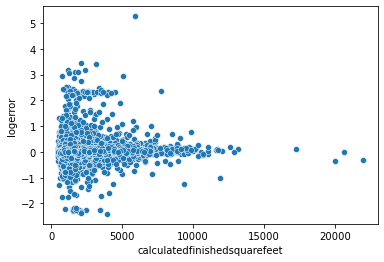

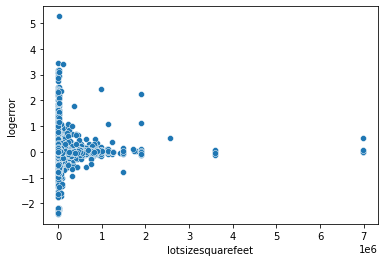

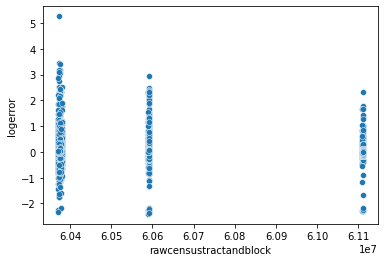

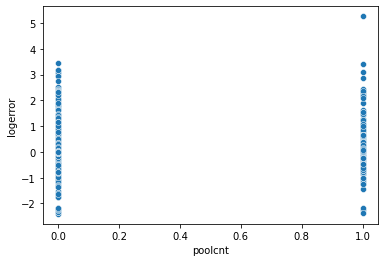

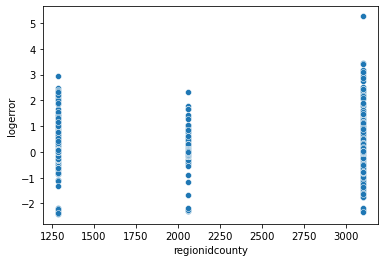

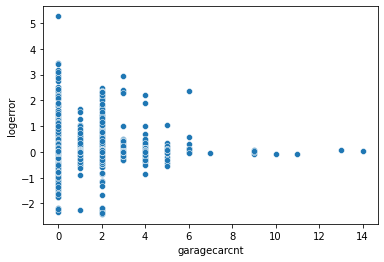

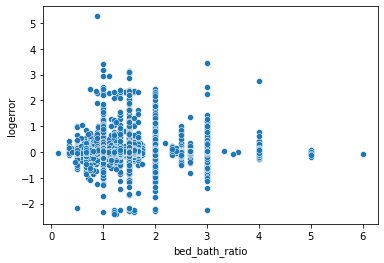

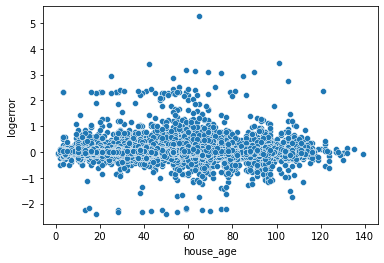

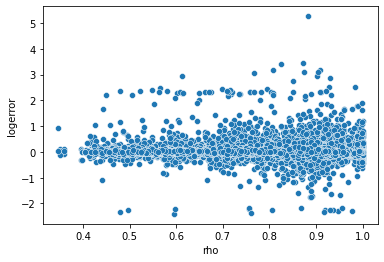

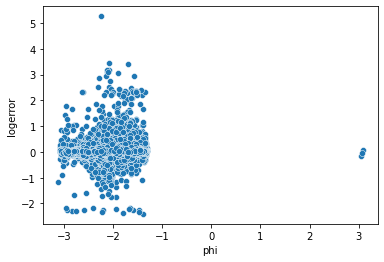

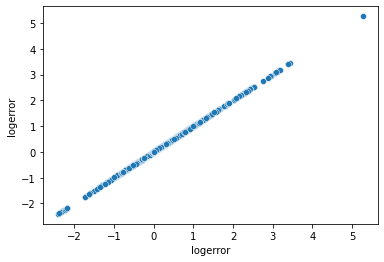

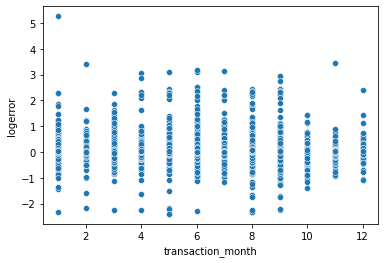

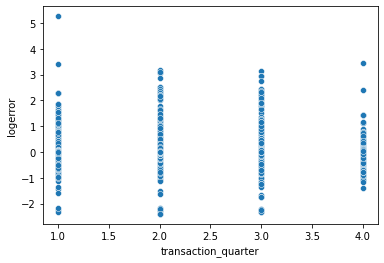

In [30]:
scatter_vs_target(train, 'logerror')

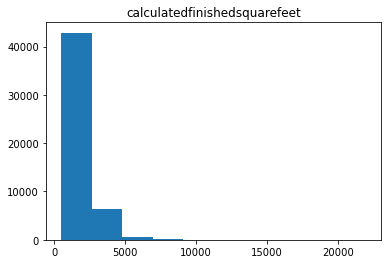

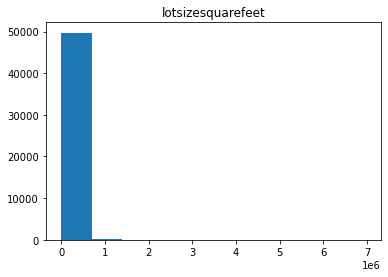

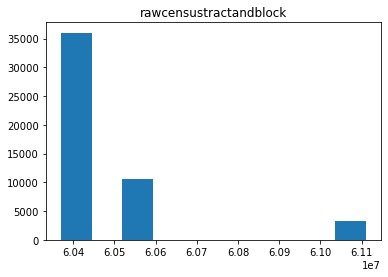

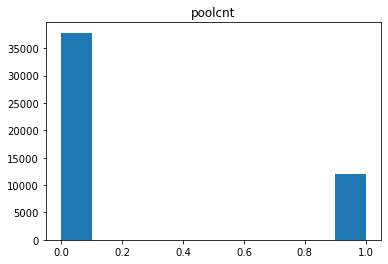

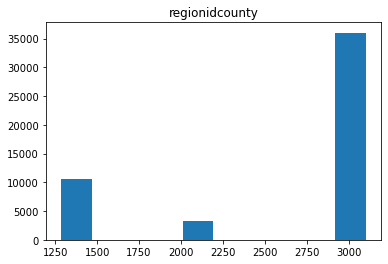

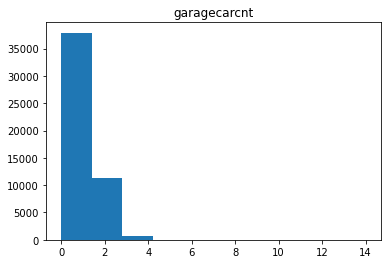

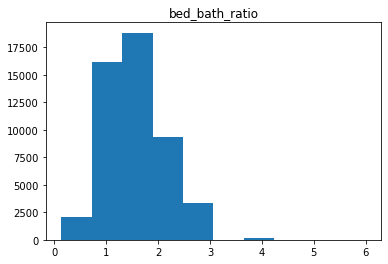

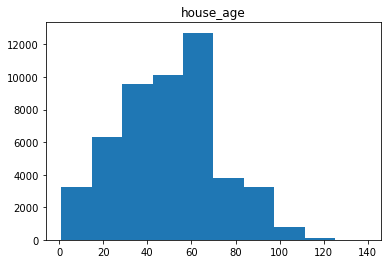

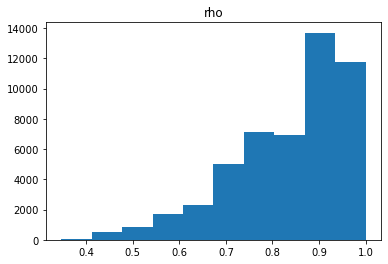

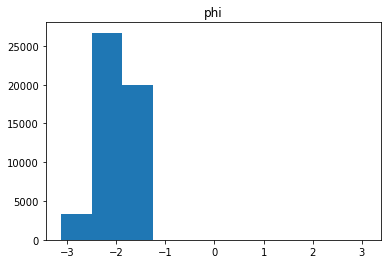

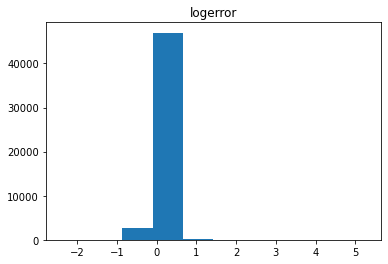

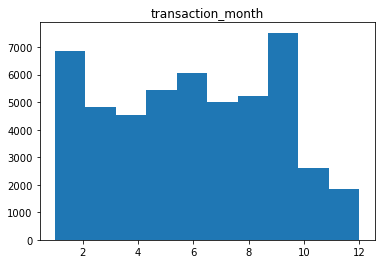

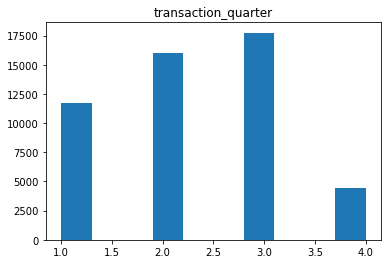

In [31]:
for col in train.columns:
    plt.hist(train[col])
    plt.title(col)
    plt.show()

In [32]:
logmean = train.logerror.mean()

In [33]:
train.columns

Index(['calculatedfinishedsquarefeet', 'lotsizesquarefeet',
       'rawcensustractandblock', 'poolcnt', 'regionidcounty', 'garagecarcnt',
       'bed_bath_ratio', 'house_age', 'rho', 'phi', 'logerror',
       'transaction_month', 'transaction_quarter'],
      dtype='object')

In [34]:
# cutting the only most extreme outliers and will handle with a robust scaler later
train = zillow_wrangle.remove_outliers(train, 3.5, ['calculatedfinishedsquarefeet','garagecarcnt'])
train.shape

(49504, 13)

In [35]:
def county_name(county):
    if county == 2061.0:
        return 'Los Angeles'
    elif county == 1286.0:
        return 'Orange'
    elif county == 3101.0:
        return 'Ventura'

train['county'] = train.regionidcounty.apply(county_name)
validate['county'] = train.regionidcounty.apply(county_name)
test['county'] = train.regionidcounty.apply(county_name)

# 

---

## Question 1 Does log error vary by county


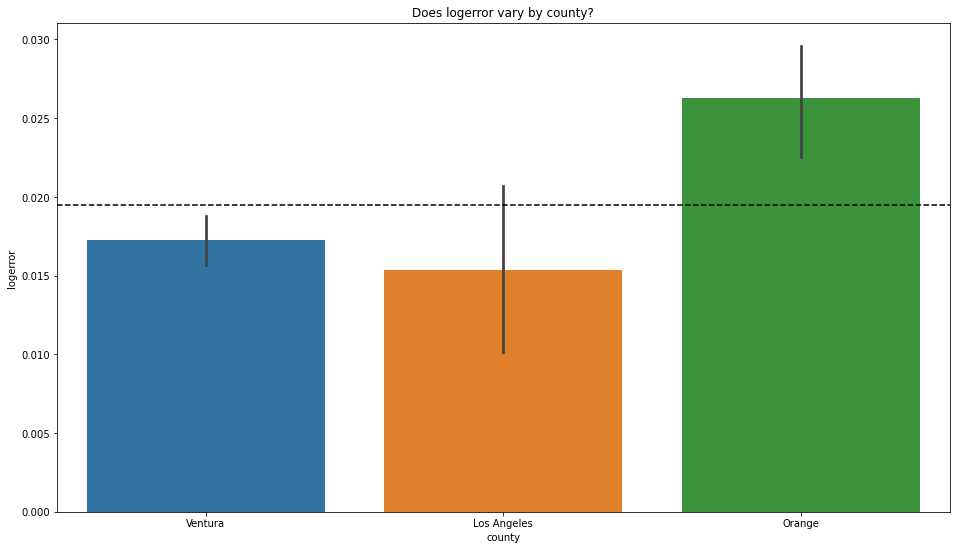

In [36]:
plt.figure(figsize=(16, 9))
sns.barplot(data = train, x='county', y='logerror')
plt.title('Does logerror vary by county?')
plt.axhline(logmean, ls = '--', color = 'black')
plt.show()

## Q2 - Do polar coordinate by bin have different log error?

In [37]:
train['polar_combo'] = train.rho * train.phi
validate['polar_combo'] = validate.rho * validate.phi
test['polar_combo'] = test.rho * test.phi


# train['polar_bin'] = pd.qcut(train['polar_combo'],q=6)
train['polar_bin'] = pd.cut(train.polar_combo, [-3.0469999999999997, -2.148, -1.891, -1.671, -1.461, -1.26, 3.018])
train.polar_bin.value_counts(ascending=False)



(-1.891, -1.671]    8286
(-3.047, -2.148]    8253
(-1.671, -1.461]    8250
(-1.26, 3.018]      8250
(-1.461, -1.26]     8237
(-2.148, -1.891]    8227
Name: polar_bin, dtype: int64

In [38]:
validate['polar_bin'] = pd.cut(validate.polar_combo, [-3.0469999999999997, -2.148, -1.891, -1.671, -1.461, -1.26, 3.018])
test['polar_bin'] = pd.cut(test.polar_combo, [-3.0469999999999997, -2.148, -1.891, -1.671, -1.461, -1.26, 3.018])

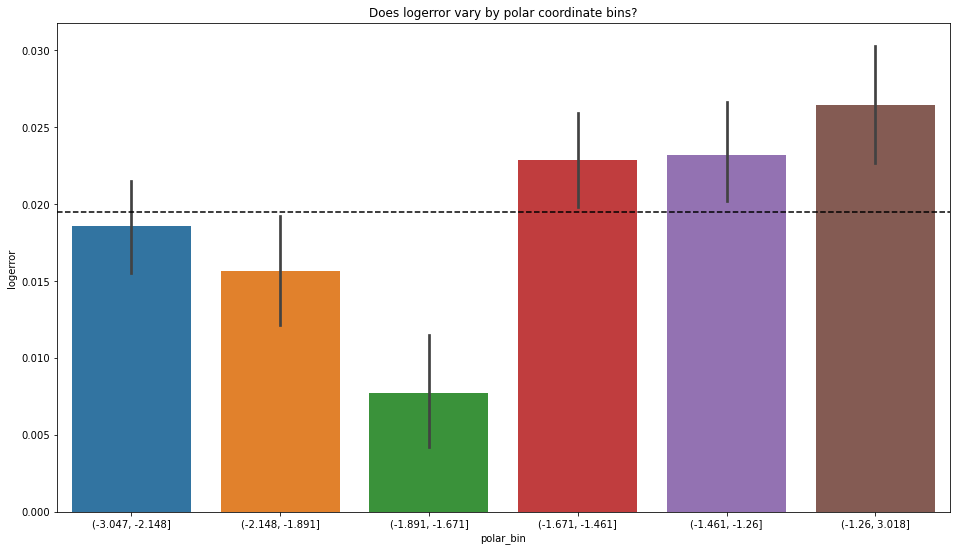

In [39]:
plt.figure(figsize=(16, 9))
sns.barplot(data = train, x='polar_bin', y='logerror')
plt.title('Does logerror vary by polar coordinate bins?')
plt.axhline(logmean, ls = '--', color = 'black')
plt.show()

# Q3 - Does transaction date affect log error?

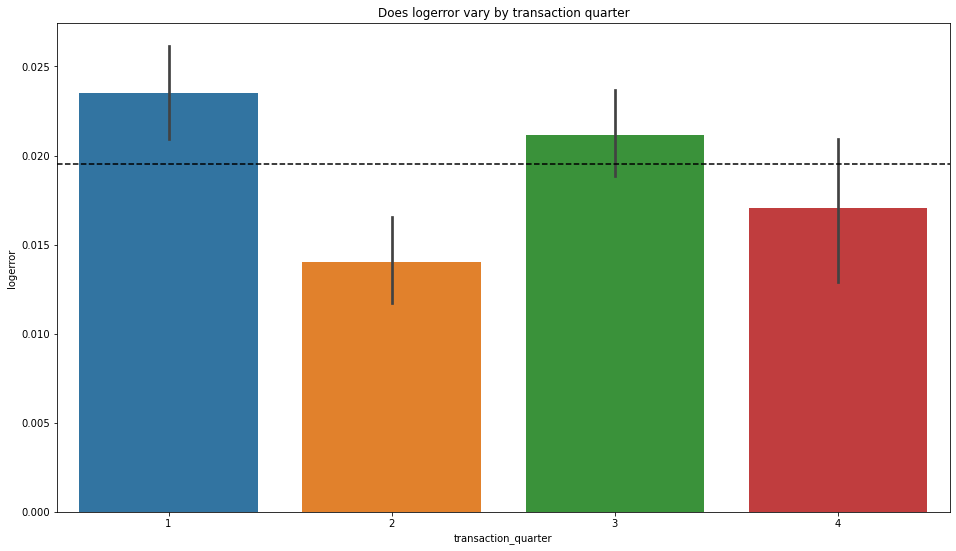

In [40]:
plt.figure(figsize=(16, 9))
sns.barplot(data = train, x='transaction_quarter', y='logerror')
plt.title('Does logerror vary by transaction quarter')
plt.axhline(logmean, ls = '--', color = 'black')
plt.show()

## Q 3

In [41]:
# train['raw_cen_bin'] = pd.qcut(train['rawcensustractandblock'],q=4)
train['raw_cen_bin'] = pd.cut(train.rawcensustractandblock, [60371011.1, 60373004.001, 60375711.022, 60590218.223, 61110091.001])
train.raw_cen_bin.value_counts(ascending=False)


(60590218.223, 61110091.001]    12381
(60375711.022, 60590218.223]    12375
(60371011.1, 60373004.001]      12374
(60373004.001, 60375711.022]    12372
Name: raw_cen_bin, dtype: int64

In [42]:
validate['raw_cen_bin'] = pd.cut(validate.rawcensustractandblock, [60371011.1, 60373004.001, 60375711.022, 60590218.223, 61110091.001])
test['raw_cen_bin'] = pd.cut(test.rawcensustractandblock, [60371011.1, 60373004.001, 60375711.022, 60590218.223, 61110091.001])

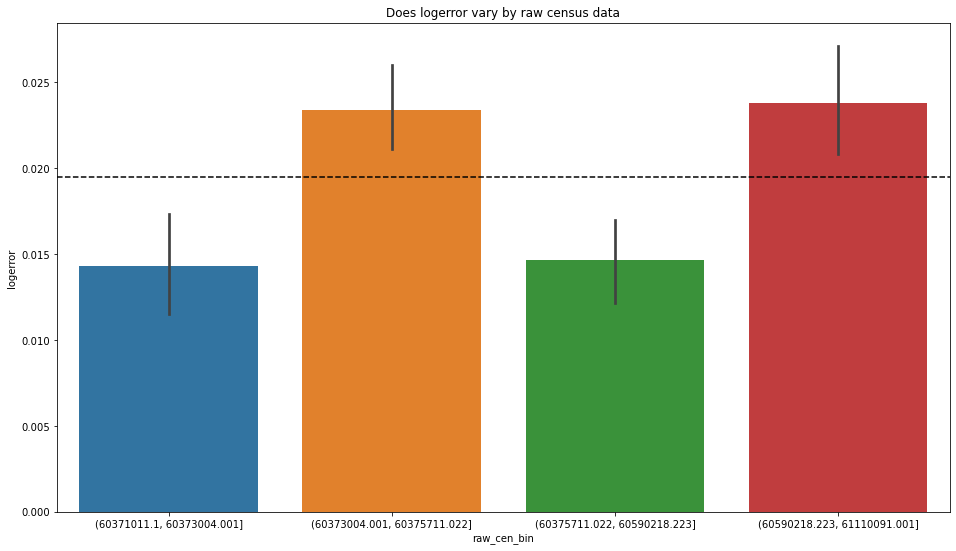

In [43]:


plt.figure(figsize=(16, 9))
sns.barplot(data = train, x='raw_cen_bin', y='logerror')
plt.title('Does logerror vary by raw census data')
plt.axhline(logmean, ls = '--', color = 'black')
plt.show()

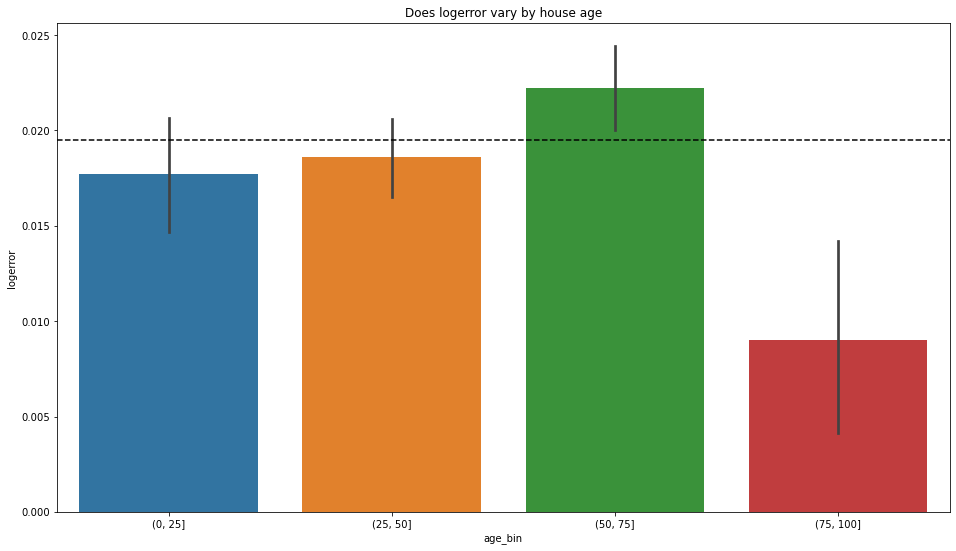

In [44]:
train['age_bin'] = pd.cut(train.house_age,[0,25, 50, 75, 100])
validate['age_bin'] = pd.cut(validate.house_age,[0,25, 50, 75, 100])
test['age_bin'] = pd.cut(test.house_age,[0,25, 50, 75, 100])

plt.figure(figsize=(16, 9))
sns.barplot(data = train, x='age_bin', y='logerror')
plt.title('Does logerror vary by house age')
plt.axhline(logmean, ls = '--', color = 'black')
plt.show()

In [45]:
train['weird_ratio'] = df.calculatedfinishedsquarefeet * df.bed_bath_ratio
validate['weird_ratio'] = df.calculatedfinishedsquarefeet * df.bed_bath_ratio
test['weird_ratio'] = df.calculatedfinishedsquarefeet * df.bed_bath_ratio

In [46]:
# train['sqft_x_bbr'] = pd.qcut(train['weird_ratio'],q=6)

train['sqft_x_bbr'] = pd.cut(train.weird_ratio, [81.59899999999999, 1464.0, 1920.0, 2355.0, 2919.0, 3600, 15090.0])
train.sqft_x_bbr.value_counts(ascending=False)


(1464.0, 1920.0]     8288
(81.599, 1464.0]     8265
(2919.0, 3600.0]     8264
(2355.0, 2919.0]     8235
(3600.0, 15090.0]    8234
(1920.0, 2355.0]     8218
Name: sqft_x_bbr, dtype: int64

In [47]:
validate['sqft_x_bbr'] = pd.cut(validate.weird_ratio, [81.59899999999999, 1464.0, 1920.0, 2355.0, 2919.0, 3600, 15090.0])
test['sqft_x_bbr'] = pd.cut(test.weird_ratio, [81.59899999999999, 1464.0, 1920.0, 2355.0, 2919.0, 3600, 15090.0])

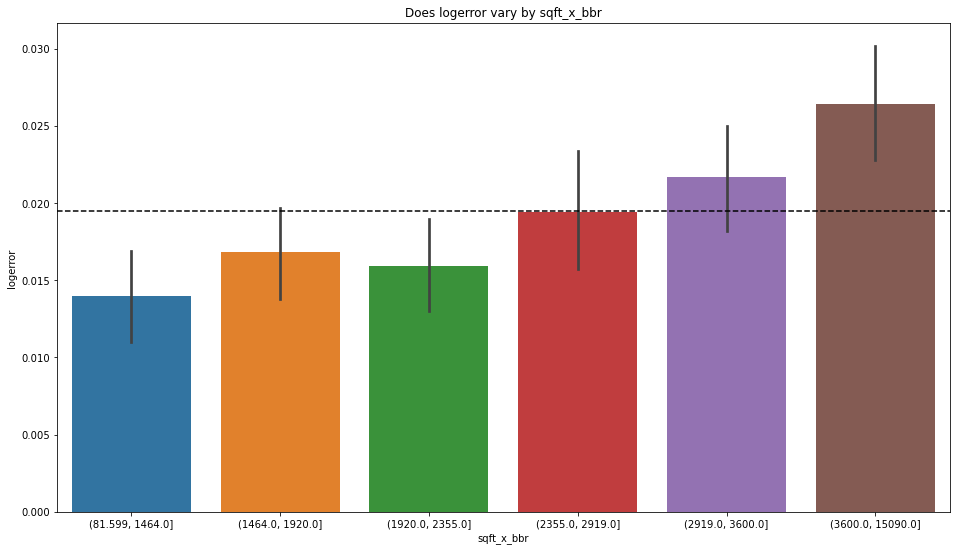

In [48]:
plt.figure(figsize=(16, 9))
sns.barplot(data = train, x='sqft_x_bbr', y='logerror')
plt.title('Does logerror vary by sqft_x_bbr')
plt.axhline(logmean, ls = '--', color = 'black')
plt.show()

In [49]:
train['cen_ratio'] = df.rawcensustractandblock / df.transaction_month
validate['cen_ratio'] = df.rawcensustractandblock / df.transaction_month
test['cen_ratio'] = df.rawcensustractandblock / df.transaction_month

# train['cen_ratio_bin'] = pd.qcut(train['cen_ratio'],q=6)
train['cen_ratio_bin'] = pd.cut(train.cen_ratio, [5030917.601, 6708412.0, 7573874.039, 10062584.918, 12118220.002, 20126400.101, 61110088.001])
train.cen_ratio_bin.value_counts(ascending=True)


(5030917.601, 6708412.0]        8248
(20126400.101, 61110088.001]    8248
(7573874.039, 10062584.918]     8249
(10062584.918, 12118220.002]    8250
(12118220.002, 20126400.101]    8253
(6708412.0, 7573874.039]        8255
Name: cen_ratio_bin, dtype: int64

In [50]:
validate['cen_ratio_bin'] = pd.cut(validate.cen_ratio, [5030917.601, 6708412.0, 7573874.039, 10062584.918, 12118220.009, 20126400.101, 61110088.001])
test['cen_ratio_bin'] = pd.cut(test.cen_ratio, [5030917.601, 6708412.0, 7573874.039, 10062584.918, 12118220.002, 20126400.101, 61110088.001])

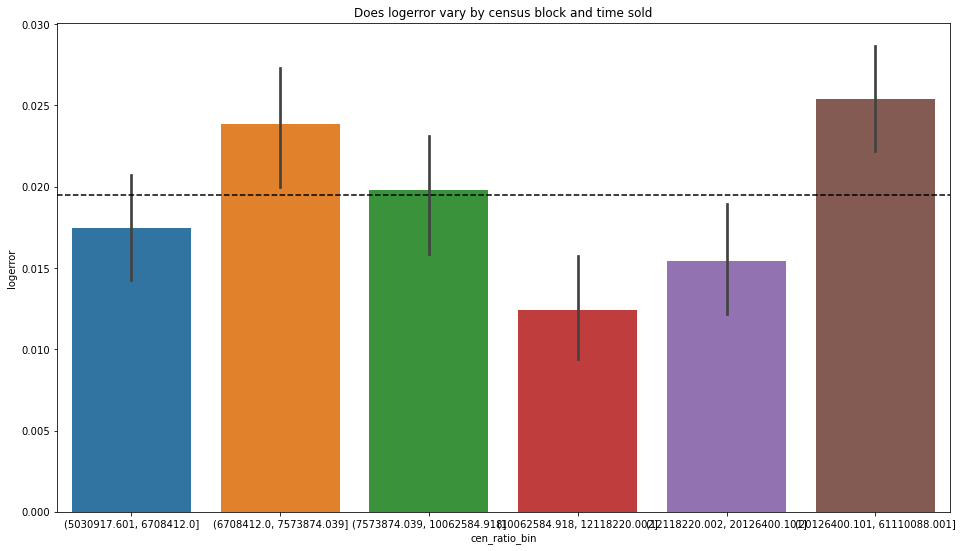

In [51]:
plt.figure(figsize=(16, 9))
sns.barplot(data = train, x='cen_ratio_bin', y='logerror')
plt.title('Does logerror vary by census block and time sold')
plt.axhline(logmean, ls = '--', color = 'black')
plt.show()

In [52]:
train['county_ratio'] = train.regionidcounty / train.transaction_month
validate['county_ratio'] = validate.regionidcounty / validate.transaction_month
test['county_ratio'] = test.regionidcounty / test.transaction_month


# train['county_ratio_bin'] = pd.qcut(train['county_ratio'],q=6)
train['county_ratio_bin'] = pd.cut(train.county_ratio, [107.166, 258.417, 344.556, 443.0, 620.2, 1033.667, 3101.0])
train.county_ratio_bin.value_counts(ascending=False)

(258.417, 344.556]    9909
(107.166, 258.417]    8843
(344.556, 443.0]      8514
(443.0, 620.2]        8471
(620.2, 1033.667]     7811
(1033.667, 3101.0]    5956
Name: county_ratio_bin, dtype: int64

In [53]:

validate['county_ratio_bin'] = pd.cut(validate.county_ratio, [107.166, 258.417, 344.556, 443.0, 620.2, 1033.667, 3101.0])
test['county_ratio_bin'] = pd.cut(test.county_ratio, [107.166, 258.417, 344.556, 443.0, 620.2, 1033.667, 3101.0])

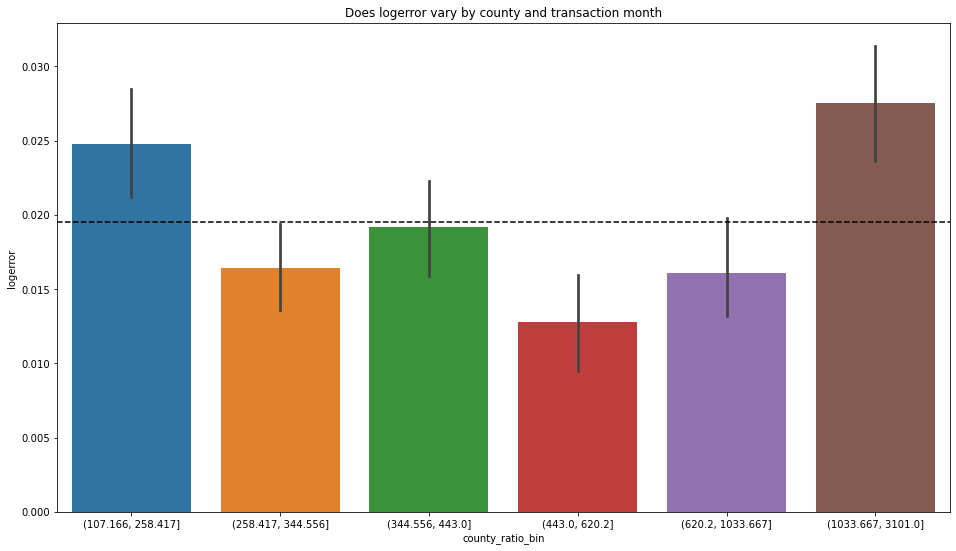

In [54]:

plt.figure(figsize=(16, 9))
sns.barplot(data = train, x='county_ratio_bin', y='logerror')
plt.title('Does logerror vary by county and transaction month')
plt.axhline(logmean, ls = '--', color = 'black')
plt.show()

The county where the house was sold and the time of year the house was sold varies in log error. Within certain months in certain counties that log error is less than average 

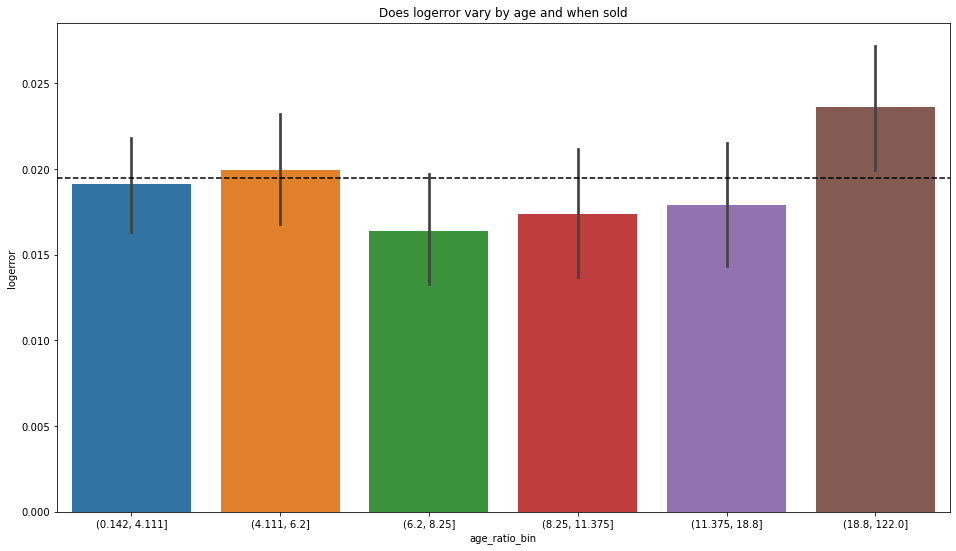

In [55]:
train['age_ratio'] = df.house_age / df.transaction_month

train['age_ratio_bin'] = pd.qcut(train['age_ratio'],q=6)

plt.figure(figsize=(16, 9))
sns.barplot(data = train, x='age_ratio_bin', y='logerror')
plt.title('Does logerror vary by age and when sold')
plt.axhline(logmean, ls = '--', color = 'black')
plt.show()

The house age and when the house was sold also offers some variance in log error 

In [56]:
# train['age_sqft_ratio'] = df.calculatedfinishedsquarefeet / df.house_age

# train['age_sqft_ratio_bin'] = pd.qcut(train['age_ratio'],q=6)

# plt.figure(figsize=(16, 9))
# sns.barplot(data = train, x='age_sqft_ratio_bin', y='logerror')
# plt.title('Does logerror vary by age and when sold')
# plt.axhline(logmean, ls = '--', color = 'black')
# plt.show()

#
---

Cluster time

In [57]:
train.columns

Index(['calculatedfinishedsquarefeet', 'lotsizesquarefeet',
       'rawcensustractandblock', 'poolcnt', 'regionidcounty', 'garagecarcnt',
       'bed_bath_ratio', 'house_age', 'rho', 'phi', 'logerror',
       'transaction_month', 'transaction_quarter', 'county', 'polar_combo',
       'polar_bin', 'raw_cen_bin', 'age_bin', 'weird_ratio', 'sqft_x_bbr',
       'cen_ratio', 'cen_ratio_bin', 'county_ratio', 'county_ratio_bin',
       'age_ratio', 'age_ratio_bin'],
      dtype='object')

In [58]:

def split_scale(df):
    # Copy a new dataframe to perform feature engineering
    scaled_df = df.copy()
    scaler = RobustScaler()
    # Split the scaled data into train, validate, test
    train, validate, test = zillow_wrangle.split_data(scaled_df)
    # Columns to scale
    cols = ['calculatedfinishedsquarefeet', 'lotsizesquarefeet', 'rawcensustractandblock', 'garagecarcnt', 'house_age', 'polar_combo', 'weird_ratio', 'cen_ratio', 'raw_cen_bin']
    # Fit numerical features to scaler
    scaler.fit(train[cols])
    # Set the features to transformed value
    train[cols] = scaler.transform(train[cols])
    validate[cols] = scaler.transform(validate[cols])
    test[cols] = scaler.transform(test[cols])
    return train, validate, test

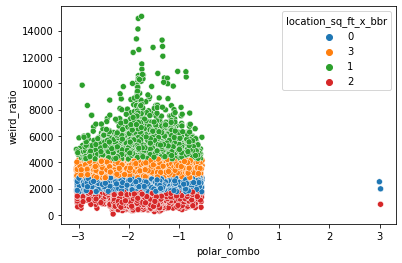

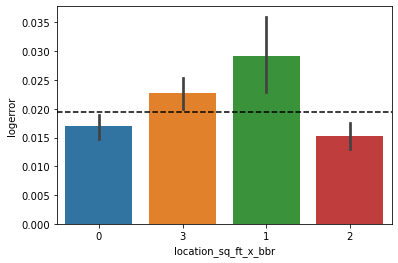

In [59]:
X1 = train[['weird_ratio', 'polar_combo']]

# Make the model
kmeans = KMeans(n_clusters=4)

# Fit the model
kmeans.fit(X1)
kmeans.predict(X1)

# add cluster column for visualization
train['location_sq_ft_x_bbr'] = kmeans.predict(X1)
# validate['location_sq_ft_x_bbr'] = kmeans.predict(X1)
# test['location_sq_ft_x_bbr'] = kmeans.predict(X1)
train.location_sq_ft_x_bbr = train.location_sq_ft_x_bbr.astype(str)
train.head()

# visualize the cluster
sns.scatterplot(data=train, y = 'weird_ratio', x = 'polar_combo', hue= 'location_sq_ft_x_bbr')
plt.show()
sns.barplot(data=train, x='location_sq_ft_x_bbr', y='logerror')
plt.axhline(logmean, ls = '--', color = 'black')

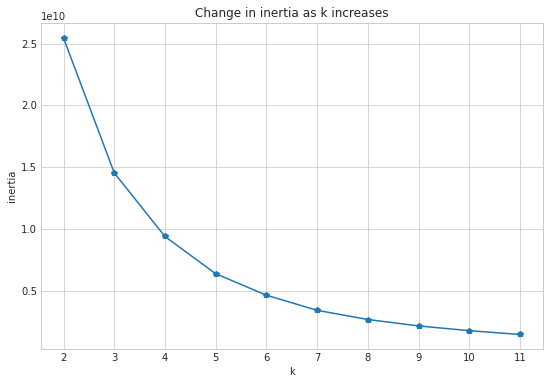

In [60]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X1).inertia_ for k in range(2, 12)}).plot(marker='p')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

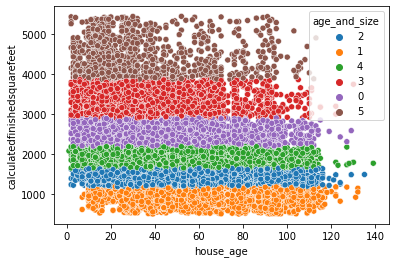

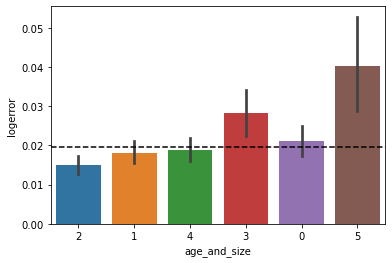

In [61]:
X2 = train[['calculatedfinishedsquarefeet', 'house_age']]

# Make the model
kmeans = KMeans(n_clusters=6)

# Fit the model
kmeans.fit(X2)
kmeans.predict(X2)

# add cluster column for visualization
train['age_and_size'] = kmeans.predict(X2)
train.age_and_size = train.age_and_size.astype(str)
train.head()

# visualize the cluster
sns.scatterplot(data=train, y = 'calculatedfinishedsquarefeet', x = 'house_age', hue= 'age_and_size')
plt.show()
sns.barplot(data=train, x='age_and_size', y='logerror')
plt.axhline(logmean, ls = '--', color = 'black')


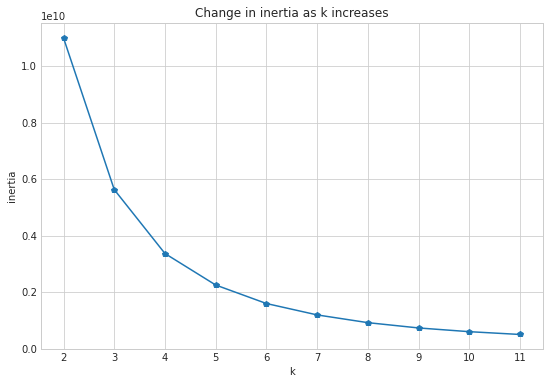

In [62]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X2).inertia_ for k in range(2, 12)}).plot(marker='p')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

In [64]:
t, p = stats.ttest_ind(train['age_and_size'],train.logerror, equal_var=False)
    
t, p / 2
a=0.05
if p < a:
        print("We reject the null hypothesis and this variable is statistically significant")
else:
        print("We fail to reject the null hypothesis and this feature is not statisitcally significant")

TypeError: unsupported operand type(s) for /: 'str' and 'int'

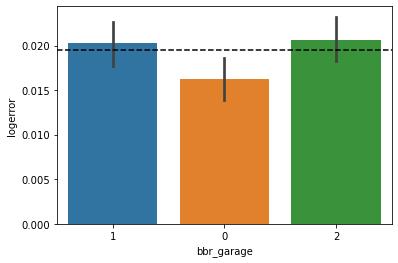

In [65]:
X3 = train[['bed_bath_ratio', 'transaction_month', 'garagecarcnt']]

# Make the model
kmeans = KMeans(n_clusters=3)

# Fit the model
kmeans.fit(X3)
kmeans.predict(X3)

# add cluster column for visualization
train['bbr_garage'] = kmeans.predict(X3)
# validate['bbr_garage'] = kmeans.predict(X3)
# test['bbr_garage'] = kmeans.predict(X3)

train.bbr_garage = train.bbr_garage.astype(str)
train.head()

# visualize the cluster
# sns.scatterplot(data=train, y = 'polar_combo', x = 'house_age', hue= 'cluster3')
# plt.show()
sns.barplot(data=train, x='bbr_garage', y='logerror')
plt.axhline(logmean, ls = '--', color = 'black')

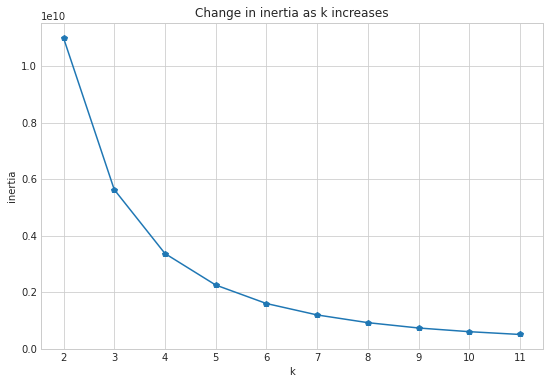

In [ ]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X2).inertia_ for k in range(2, 12)}).plot(marker='p')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

In [ ]:
train.columns

Index(['calculatedfinishedsquarefeet', 'lotsizesquarefeet',
       'rawcensustractandblock', 'poolcnt', 'regionidcounty', 'garagecarcnt',
       'bed_bath_ratio', 'house_age', 'rho', 'phi', 'logerror',
       'transaction_month', 'transaction_quarter', 'county', 'polar_combo',
       'polar_bin', 'raw_cen_bin', 'age_bin', 'weird_ratio', 'sqft_x_bbr',
       'cen_ratio', 'cen_ratio_bin', 'county_ratio', 'county_ratio_bin',
       'age_ratio', 'age_ratio_bin', 'location_sq_ft_x_bbr', 'age_and_size',
       'bbr_garage'],
      dtype='object')

In [ ]:
def select_rfe(x, y, k):
    model = LinearRegression()
    rfe = RFE(model, n_features_to_select= k)
    rfe.fit(x, y)
    return x.columns[rfe.get_support()]

In [ ]:
cols = ['polar_bin', 'raw_cen_bin', 'age_bin', 'sqft_x_bbr', 'county_ratio_bin', 'county']
train_dummy = pd.get_dummies(train[cols], dummy_na=False, drop_first=False)
x_train = pd.concat([train, train_dummy], axis =1)

validate_dummy = pd.get_dummies(validate[cols], dummy_na=False, drop_first=False)
x_validate = pd.concat([validate, validate_dummy], axis =1)

test_dummy = pd.get_dummies(test[cols], dummy_na=False, drop_first=False)
x_test = pd.concat([test, test_dummy], axis =1)

In [ ]:
x_validate.head()

,calculatedfinishedsquarefeet,lotsizesquarefeet,rawcensustractandblock,poolcnt,regionidcounty,garagecarcnt,bed_bath_ratio,house_age,rho,phi,...,"sqft_x_bbr_(1920.0, 2355.0]","sqft_x_bbr_(2355.0, 2919.0]","sqft_x_bbr_(2919.0, 3600.0]","sqft_x_bbr_(3600.0, 15090.0]","county_ratio_bin_(107.166, 258.417]","county_ratio_bin_(258.417, 344.556]","county_ratio_bin_(344.556, 443.0]","county_ratio_bin_(443.0, 620.2]","county_ratio_bin_(620.2, 1033.667]","county_ratio_bin_(1033.667, 3101.0]"
68819,2851.0,4347.0,6.111004e+07,0,2061.0,2.0,1.666667,11.0,0.932021,-2.985968,...,0,0,0,1,1,0,0,0,0,0
7184,1082.0,5000.0,6.037571e+07,0,3101.0,0.0,3.000000,67.0,0.756195,-1.879833,...,0,0,1,0,0,1,0,0,0,0
67610,1387.0,16281.0,6.037621e+07,0,3101.0,0.0,1.000000,29.0,0.781132,-2.139072,...,0,0,0,0,0,0,0,0,1,0
21656,1507.0,5811.0,6.037120e+07,0,3101.0,0.0,1.500000,69.0,0.946826,-2.207732,...,1,0,0,0,0,1,0,0,0,0
23446,1060.0,6149.0,6.037541e+07,0,3101.0,0.0,3.000000,69.0,0.805399,-2.035322,...,0,0,1,0,0,1,0,0,0,0


In [ ]:
x_train = x_train.drop(columns=['polar_bin', 'raw_cen_bin', 'age_bin', 'sqft_x_bbr', 'county_ratio_bin', 'county', 'county_Los Angeles', 'county_Orange', 'county_Ventura','location_sq_ft_x_bbr', 'age_and_size', 'bbr_garage', 'age_ratio_bin', 'cen_ratio_bin'])
# x_train.drop(columns=['polar_bin', 'raw_cen_bin', 'age_bin', 'sqft_x_bbr', 'county_ratio_bin', 'county'])

In [ ]:
X_train = x_train.drop(columns = 'logerror')
X_validate = x_validate.drop(columns = 'logerror')
X_test = x_test.drop(columns = 'logerror')

y_train = x_train['logerror']
y_validate = x_validate['logerror']
y_test = x_test['logerror']

In [ ]:
X_train.columns

Index(['calculatedfinishedsquarefeet', 'lotsizesquarefeet',
       'rawcensustractandblock', 'poolcnt', 'regionidcounty', 'garagecarcnt',
       'bed_bath_ratio', 'house_age', 'rho', 'phi', 'transaction_month',
       'transaction_quarter', 'polar_combo', 'weird_ratio', 'cen_ratio',
       'county_ratio', 'age_ratio', 'polar_bin_(-3.047, -2.148]',
       'polar_bin_(-2.148, -1.891]', 'polar_bin_(-1.891, -1.671]',
       'polar_bin_(-1.671, -1.461]', 'polar_bin_(-1.461, -1.26]',
       'polar_bin_(-1.26, 3.018]', 'raw_cen_bin_(60371011.1, 60373004.001]',
       'raw_cen_bin_(60373004.001, 60375711.022]',
       'raw_cen_bin_(60375711.022, 60590218.223]',
       'raw_cen_bin_(60590218.223, 61110091.001]', 'age_bin_(0, 25]',
       'age_bin_(25, 50]', 'age_bin_(50, 75]', 'age_bin_(75, 100]',
       'sqft_x_bbr_(81.599, 1464.0]', 'sqft_x_bbr_(1464.0, 1920.0]',
       'sqft_x_bbr_(1920.0, 2355.0]', 'sqft_x_bbr_(2355.0, 2919.0]',
       'sqft_x_bbr_(2919.0, 3600.0]', 'sqft_x_bbr_(3600.0, 150

In [ ]:
select_rfe(X_train, y_train, 16)

Index(['rho', 'phi', 'polar_combo', 'age_bin_(75, 100]',
       'sqft_x_bbr_(81.599, 1464.0]', 'sqft_x_bbr_(1464.0, 1920.0]',
       'sqft_x_bbr_(1920.0, 2355.0]', 'sqft_x_bbr_(2355.0, 2919.0]',
       'sqft_x_bbr_(2919.0, 3600.0]', 'sqft_x_bbr_(3600.0, 15090.0]',
       'county_ratio_bin_(107.166, 258.417]',
       'county_ratio_bin_(258.417, 344.556]',
       'county_ratio_bin_(344.556, 443.0]', 'county_ratio_bin_(443.0, 620.2]',
       'county_ratio_bin_(620.2, 1033.667]',
       'county_ratio_bin_(1033.667, 3101.0]'],
      dtype='object')

In [ ]:
X_train = X_train[[ 'rho', 'phi', 'polar_combo', 'age_bin_(75, 100]',
       'sqft_x_bbr_(81.599, 1464.0]', 'sqft_x_bbr_(1464.0, 1920.0]',
       'sqft_x_bbr_(1920.0, 2355.0]', 'sqft_x_bbr_(2355.0, 2919.0]',
       'sqft_x_bbr_(2919.0, 3600.0]', 'sqft_x_bbr_(3600.0, 15090.0]',
       'county_ratio_bin_(107.166, 258.417]',
       'county_ratio_bin_(258.417, 344.556]',
       'county_ratio_bin_(344.556, 443.0]', 'county_ratio_bin_(443.0, 620.2]',
       'county_ratio_bin_(620.2, 1033.667]',
       'county_ratio_bin_(1033.667, 3101.0]']]
# [['house_age', 'bed_bath_ratio', 'sq_ft', 'pool_encoded', 'garages']]
X_validate= X_validate[[ 'rho', 'phi', 'polar_combo', 'age_bin_(75, 100]',
       'sqft_x_bbr_(81.599, 1464.0]', 'sqft_x_bbr_(1464.0, 1920.0]',
       'sqft_x_bbr_(1920.0, 2355.0]', 'sqft_x_bbr_(2355.0, 2919.0]',
       'sqft_x_bbr_(2919.0, 3600.0]', 'sqft_x_bbr_(3600.0, 15090.0]',
       'county_ratio_bin_(107.166, 258.417]',
       'county_ratio_bin_(258.417, 344.556]',
       'county_ratio_bin_(344.556, 443.0]', 'county_ratio_bin_(443.0, 620.2]',
       'county_ratio_bin_(620.2, 1033.667]',
       'county_ratio_bin_(1033.667, 3101.0]']] 
# [['house_age', 'bed_bath_ratio', 'sq_ft', 'pool_encoded', 'garages']]
X_test= X_test[[ 'rho', 'phi', 'polar_combo', 'age_bin_(75, 100]',
       'sqft_x_bbr_(81.599, 1464.0]', 'sqft_x_bbr_(1464.0, 1920.0]',
       'sqft_x_bbr_(1920.0, 2355.0]', 'sqft_x_bbr_(2355.0, 2919.0]',
       'sqft_x_bbr_(2919.0, 3600.0]', 'sqft_x_bbr_(3600.0, 15090.0]',
       'county_ratio_bin_(107.166, 258.417]',
       'county_ratio_bin_(258.417, 344.556]',
       'county_ratio_bin_(344.556, 443.0]', 'county_ratio_bin_(443.0, 620.2]',
       'county_ratio_bin_(620.2, 1033.667]',
       'county_ratio_bin_(1033.667, 3101.0]']]
# [['house_age', 'bed_bath_ratio', 'sq_ft', 'pool_encoded', 'garages']]

predictions_reg = pd.DataFrame({
    'actual': x_validate['logerror']
}) 

In [ ]:
# Setting up and fitting the data for linear regression using my sqrt data for normalization
liner_reg = LinearRegression()

liner_reg.fit(X_train, y_train)

predictions_reg['simple_lm'] = liner_reg.predict(X_validate)

In [ ]:
# Setting up and fitting the lars to my normalized data

lars_reg = LassoLars(alpha=2.0)

lars_reg.fit(X_train, y_train)


predictions_reg['Lasso_Lars'] = lars_reg.predict(X_validate)

/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLars())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(


In [ ]:
# Setting up and fitting the TweedieRegressor to the non-normalized data
tweedie_reg = TweedieRegressor(power=0, alpha=0.5)

tweedie_reg.fit(X_train, y_train)


predictions_reg['tweedie'] = tweedie_reg.predict(X_validate)

In [ ]:
predictions_reg['baseline'] = x_train.logerror.mean()
predictions_reg.head()

,actual,simple_lm,Lasso_Lars,tweedie,baseline
68819,0.075640,0.019669,0.01905,0.018553,0.01905
7184,0.187300,0.021043,0.01905,0.019953,0.01905
67610,-0.073515,0.011661,0.01905,0.017330,0.01905
21656,0.019800,0.013401,0.01905,0.016715,0.01905
23446,0.018800,0.019396,0.01905,0.019287,0.01905


In [ ]:
def calculate_rmse(y_predicted):
    return mean_squared_error(predictions_reg.actual, y_predicted, squared=False)

predictions_reg.apply(calculate_rmse).sort_values()

actual        0.000000e+00
tweedie       1.615348e-01
Lasso_Lars    1.615794e-01
baseline      1.615794e-01
simple_lm     2.195888e+07
dtype: float64

In [ ]:
# make the polynomial features to get a new set of features
poly_feat = PolynomialFeatures(degree=4, include_bias=False, interaction_only=False)

poly_feat.fit(X_train)

x_train_poly = pd.DataFrame(
    poly_feat.transform(X_train),
    columns=poly_feat.get_feature_names(X_train.columns),
    index=train.index,
)

x_train_poly.head()

/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,rho,phi,polar_combo,"age_bin_(75, 100]","sqft_x_bbr_(81.599, 1464.0]","sqft_x_bbr_(1464.0, 1920.0]","sqft_x_bbr_(1920.0, 2355.0]","sqft_x_bbr_(2355.0, 2919.0]","sqft_x_bbr_(2919.0, 3600.0]","sqft_x_bbr_(3600.0, 15090.0]",...,"county_ratio_bin_(443.0, 620.2]^2 county_ratio_bin_(1033.667, 3101.0]^2","county_ratio_bin_(443.0, 620.2] county_ratio_bin_(620.2, 1033.667]^3","county_ratio_bin_(443.0, 620.2] county_ratio_bin_(620.2, 1033.667]^2 county_ratio_bin_(1033.667, 3101.0]","county_ratio_bin_(443.0, 620.2] county_ratio_bin_(620.2, 1033.667] county_ratio_bin_(1033.667, 3101.0]^2","county_ratio_bin_(443.0, 620.2] county_ratio_bin_(1033.667, 3101.0]^3","county_ratio_bin_(620.2, 1033.667]^4","county_ratio_bin_(620.2, 1033.667]^3 county_ratio_bin_(1033.667, 3101.0]","county_ratio_bin_(620.2, 1033.667]^2 county_ratio_bin_(1033.667, 3101.0]^2","county_ratio_bin_(620.2, 1033.667] county_ratio_bin_(1033.667, 3101.0]^3","county_ratio_bin_(1033.667, 3101.0]^4"
55088,0.997643,-1.571349,-1.567646,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25404,0.959289,-2.058118,-1.974329,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31303,0.844851,-1.670169,-1.411043,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18043,0.874309,-2.115829,-1.849888,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3247,0.853753,-1.851100,-1.580382,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
lm = LinearRegression()
lm.fit(x_train_poly, y_train)

x_validate_poly = poly_feat.transform(X_validate)
predictions_reg['polynomial degree 2'] = lm.predict(x_validate_poly)


/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [ ]:
def calculate_rmse3(y_predicted):
    return mean_squared_error(predictions_reg.actual, y_predicted, squared=False)

predictions_reg.apply(calculate_rmse3).sort_values()

actual                 0.000000e+00
tweedie                1.615348e-01
Lasso_Lars             1.615794e-01
baseline               1.615794e-01
simple_lm              2.195888e+07
polynomial degree 2    6.389542e+07
dtype: float64